In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import seaborn as sns

In [2]:
data=pd.read_csv('ML_Data_48.csv')

In [3]:
data=data.drop(['Z_jerk_mean', 'X_jerk_mean', 'total_jerk_mean', 'Y_jerk_mean','X_jerk_mean','X_jerk_min', 'X_min', 'timestamp_range'], axis=1)

In [4]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

In [5]:
x=data.drop(['label'], axis=1)
y=data['label']

In [6]:
scale=StandardScaler()
x=scale.fit_transform(x)

In [7]:
x_train, x_t, y_train, y_t= train_test_split(x,y,test_size=0.3, random_state=42)
x_train.shape, x_t.shape

((2614, 40), (1121, 40))

In [8]:
x_val, x_test, y_val, y_test= train_test_split(x_t, y_t, test_size=0.15, random_state=42)
x_val.shape, x_test.shape

((952, 40), (169, 40))

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers, models, optimizers

2024-12-28 04:59:07.875005: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-28 04:59:07.893769: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-28 04:59:07.921125: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-28 04:59:07.921153: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-28 04:59:07.921170: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [10]:
class TransformerEncoder(layers.Layer):
    def __init__(self, num_heads, ff_dim, input_dim, dropout_rate, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(input_dim)  # Match the input dimension for residual connection
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
    
    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build Transformer Model for Tabular Data
def build_transformer_model(input_dim, output_dim, num_heads, ff_dim, num_transformer_blocks, dropout_rate):
    inputs = layers.Input(shape=(input_dim,))
    
    # Reshape to 3D for multi-head attention
    x = layers.Reshape((1, input_dim))(inputs)
    
    # Stack Transformer Blocks
    for _ in range(num_transformer_blocks):
        x = TransformerEncoder(num_heads, ff_dim, input_dim, dropout_rate)(x)
    
    x = layers.Flatten()(x)
    
    # Output layer for classification
    outputs = layers.Dense(output_dim, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

In [11]:
# Hyperparameters
input_dim = x_train.shape[1]  # Number of features
output_dim = len(y_train.unique())  # Number of classes for classification
num_heads = 8
ff_dim = 64
num_transformer_blocks = 4
dropout_rate = 0.1
learning_rate = 0.001
batch_size = 32
num_epochs = 400

In [12]:
model = build_transformer_model(input_dim, output_dim, num_heads, ff_dim, num_transformer_blocks, dropout_rate)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history=model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data= (x_val, y_val))

Epoch 1/400
82/82 [==============================] - 5s 11ms/step - loss: 1.5831 - accuracy: 0.4139 - val_loss: 1.2961 - val_accuracy: 0.4947
Epoch 2/400
82/82 [==============================] - 1s 6ms/step - loss: 1.2624 - accuracy: 0.5295 - val_loss: 1.1704 - val_accuracy: 0.5662
Epoch 3/400
82/82 [==============================] - 1s 7ms/step - loss: 1.1465 - accuracy: 0.5696 - val_loss: 1.1201 - val_accuracy: 0.5903
Epoch 4/400
82/82 [==============================] - 0s 6ms/step - loss: 1.0621 - accuracy: 0.6071 - val_loss: 1.1091 - val_accuracy: 0.5977
Epoch 5/400
82/82 [==============================] - 1s 6ms/step - loss: 1.0265 - accuracy: 0.6232 - val_loss: 0.9779 - val_accuracy: 0.6345
Epoch 6/400
82/82 [==============================] - 1s 6ms/step - loss: 0.9741 - accuracy: 0.6484 - val_loss: 0.9803 - val_accuracy: 0.6481
Epoch 7/400
82/82 [==============================] - 1s 7ms/step - loss: 0.9408 - accuracy: 0.6511 - val_loss: 0.9504 - val_accuracy: 0.6807
Epoch 8/400


Epoch 59/400
82/82 [==============================] - 0s 6ms/step - loss: 0.3319 - accuracy: 0.8803 - val_loss: 0.7581 - val_accuracy: 0.7847
Epoch 60/400
82/82 [==============================] - 0s 6ms/step - loss: 0.3113 - accuracy: 0.8879 - val_loss: 0.7267 - val_accuracy: 0.7763
Epoch 61/400
82/82 [==============================] - 0s 6ms/step - loss: 0.3288 - accuracy: 0.8772 - val_loss: 0.6724 - val_accuracy: 0.7962
Epoch 62/400
82/82 [==============================] - 0s 6ms/step - loss: 0.3233 - accuracy: 0.8810 - val_loss: 0.7954 - val_accuracy: 0.7710
Epoch 63/400
82/82 [==============================] - 0s 6ms/step - loss: 0.3111 - accuracy: 0.8868 - val_loss: 0.7896 - val_accuracy: 0.7815
Epoch 64/400
82/82 [==============================] - 1s 6ms/step - loss: 0.2878 - accuracy: 0.8967 - val_loss: 0.8653 - val_accuracy: 0.7731
Epoch 65/400
82/82 [==============================] - 1s 7ms/step - loss: 0.2776 - accuracy: 0.9032 - val_loss: 0.7773 - val_accuracy: 0.7763
Epoch 

82/82 [==============================] - 0s 6ms/step - loss: 0.1721 - accuracy: 0.9376 - val_loss: 0.7704 - val_accuracy: 0.8025
Epoch 117/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1661 - accuracy: 0.9373 - val_loss: 0.8287 - val_accuracy: 0.7931
Epoch 118/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1917 - accuracy: 0.9285 - val_loss: 0.8077 - val_accuracy: 0.7994
Epoch 119/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1760 - accuracy: 0.9365 - val_loss: 0.8125 - val_accuracy: 0.7910
Epoch 120/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1646 - accuracy: 0.9472 - val_loss: 0.8111 - val_accuracy: 0.8162
Epoch 121/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1645 - accuracy: 0.9411 - val_loss: 0.8470 - val_accuracy: 0.8078
Epoch 122/400
82/82 [==============================] - 0s 6ms/step - loss: 0.2113 - accuracy: 0.9269 - val_loss: 0.8268 - val_accuracy: 0.8004
Epoch 123/400

82/82 [==============================] - 0s 6ms/step - loss: 0.1446 - accuracy: 0.9484 - val_loss: 0.9548 - val_accuracy: 0.7815
Epoch 174/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1260 - accuracy: 0.9549 - val_loss: 0.9201 - val_accuracy: 0.7931
Epoch 175/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1303 - accuracy: 0.9526 - val_loss: 0.9412 - val_accuracy: 0.7889
Epoch 176/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1126 - accuracy: 0.9575 - val_loss: 0.9432 - val_accuracy: 0.8004
Epoch 177/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1038 - accuracy: 0.9610 - val_loss: 0.9427 - val_accuracy: 0.7952
Epoch 178/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1845 - accuracy: 0.9331 - val_loss: 0.9020 - val_accuracy: 0.8025
Epoch 179/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1517 - accuracy: 0.9464 - val_loss: 0.9334 - val_accuracy: 0.7941
Epoch 180/400

82/82 [==============================] - 1s 6ms/step - loss: 0.1056 - accuracy: 0.9621 - val_loss: 0.9445 - val_accuracy: 0.7973
Epoch 231/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1181 - accuracy: 0.9533 - val_loss: 1.0609 - val_accuracy: 0.7899
Epoch 232/400
82/82 [==============================] - 0s 6ms/step - loss: 0.0867 - accuracy: 0.9717 - val_loss: 0.9476 - val_accuracy: 0.8046
Epoch 233/400
82/82 [==============================] - 0s 6ms/step - loss: 0.0889 - accuracy: 0.9675 - val_loss: 0.9957 - val_accuracy: 0.7941
Epoch 234/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1029 - accuracy: 0.9648 - val_loss: 0.9855 - val_accuracy: 0.8057
Epoch 235/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1001 - accuracy: 0.9610 - val_loss: 0.9334 - val_accuracy: 0.7983
Epoch 236/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1337 - accuracy: 0.9499 - val_loss: 0.9499 - val_accuracy: 0.8088
Epoch 237/400

82/82 [==============================] - 0s 6ms/step - loss: 0.0760 - accuracy: 0.9748 - val_loss: 1.0413 - val_accuracy: 0.7868
Epoch 288/400
82/82 [==============================] - 0s 6ms/step - loss: 0.0950 - accuracy: 0.9610 - val_loss: 0.9949 - val_accuracy: 0.7983
Epoch 289/400
82/82 [==============================] - 0s 6ms/step - loss: 0.0913 - accuracy: 0.9652 - val_loss: 1.1539 - val_accuracy: 0.7847
Epoch 290/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1580 - accuracy: 0.9449 - val_loss: 1.1157 - val_accuracy: 0.7805
Epoch 291/400
82/82 [==============================] - 0s 6ms/step - loss: 0.0975 - accuracy: 0.9644 - val_loss: 1.0205 - val_accuracy: 0.7941
Epoch 292/400
82/82 [==============================] - 1s 6ms/step - loss: 0.0765 - accuracy: 0.9732 - val_loss: 0.9887 - val_accuracy: 0.7878
Epoch 293/400
82/82 [==============================] - 1s 6ms/step - loss: 0.0845 - accuracy: 0.9690 - val_loss: 0.9865 - val_accuracy: 0.7889
Epoch 294/400

82/82 [==============================] - 0s 6ms/step - loss: 0.0835 - accuracy: 0.9690 - val_loss: 1.0021 - val_accuracy: 0.8015
Epoch 345/400
82/82 [==============================] - 0s 6ms/step - loss: 0.0612 - accuracy: 0.9797 - val_loss: 1.0039 - val_accuracy: 0.8004
Epoch 346/400
82/82 [==============================] - 0s 6ms/step - loss: 0.0773 - accuracy: 0.9717 - val_loss: 1.0432 - val_accuracy: 0.8025
Epoch 347/400
82/82 [==============================] - 1s 6ms/step - loss: 0.0667 - accuracy: 0.9767 - val_loss: 1.0476 - val_accuracy: 0.8036
Epoch 348/400
82/82 [==============================] - 1s 6ms/step - loss: 0.0899 - accuracy: 0.9675 - val_loss: 1.1499 - val_accuracy: 0.7742
Epoch 349/400
82/82 [==============================] - 1s 6ms/step - loss: 0.2129 - accuracy: 0.9288 - val_loss: 1.0482 - val_accuracy: 0.7910
Epoch 350/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1324 - accuracy: 0.9507 - val_loss: 1.0168 - val_accuracy: 0.7826
Epoch 351/400

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 reshape (Reshape)           (None, 1, 40)             0         
                                                                 
 transformer_encoder (Trans  (None, 1, 40)             57584     
 formerEncoder)                                                  
                                                                 
 transformer_encoder_1 (Tra  (None, 1, 40)             57584     
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_2 (Tra  (None, 1, 40)             57584     
 nsformerEncoder)                                                
                                                             

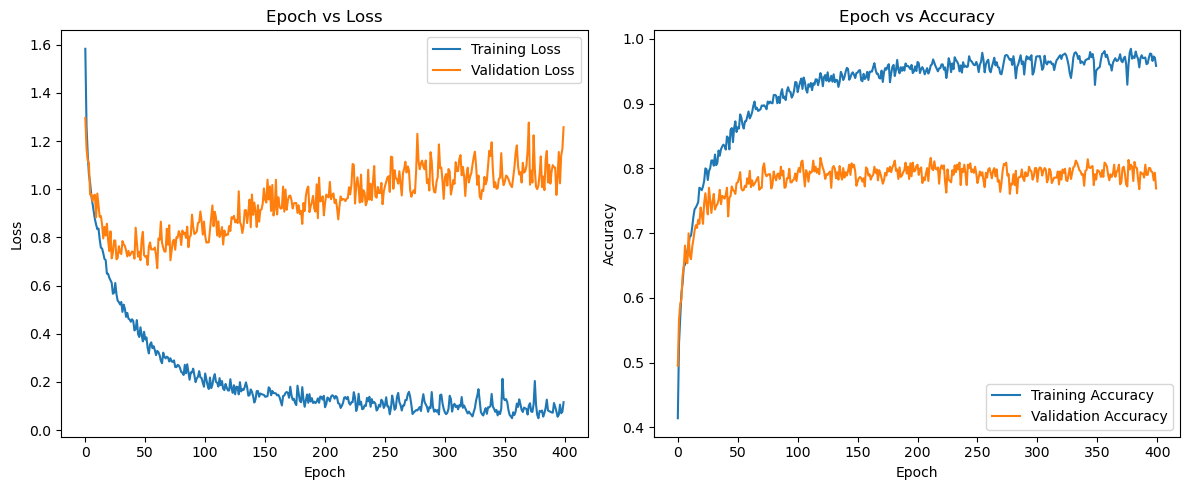

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 96.48%
Test Accuracy: 79.29%


6/6 [==============================] - 0s 3ms/step


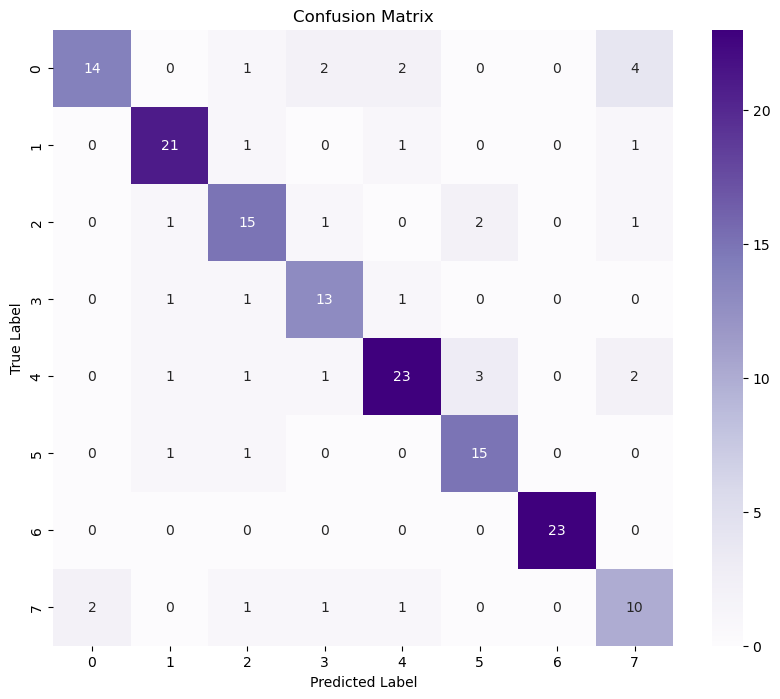

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.61      0.72        23
           1       0.84      0.88      0.86        24
           2       0.71      0.75      0.73        20
           3       0.72      0.81      0.76        16
           4       0.82      0.74      0.78        31
           5       0.75      0.88      0.81        17
           6       1.00      1.00      1.00        23
           7       0.56      0.67      0.61        15

    accuracy                           0.79       169
   macro avg       0.78      0.79      0.78       169
weighted avg       0.80      0.79      0.79       169



In [17]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

if len(y_test.shape) == 1 or y_test.shape[1] == 1:
    y_true = y_test  
else:
    y_true = np.argmax(y_test, axis=1)  


conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(len(np.unique(y_true)))])
print("Classification Report:")
print(class_report)